# Experimental Data Analysis (EDA)

This notebook presents an initial analyisis of [Kaggle's 'NYC Bus' dataset](https://www.kaggle.com/datasets/stoney71/new-york-city-transport-statistics), with id `stoney71/new-york-city-transport-statistics`.

In addition to functions to load data and pre-processing functions to clean the data, this notebook presents a simple case of bus delay prediction given a tuple `(bus line, bus station, weekday, time of day)`, using a linear regression model.

More specifically, this notebook:

1. Defines re-usable functions to load NYC bus data and pre-process it
2. Defines test functions to validate behaviour of some of the pre-processing functions
3. Shows a simple initial analysis of the data: distribution of bus stop delays (in seconds), relationship between bus stop delays and time of the day.
4. Example of training and validation of a simple linear-regression-based bus delay predictor model, which takes a `(bus line, bus station, weekday, time of day)` tuple as input features.


In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from pathlib import Path

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [2]:
# definitions
DATA_DIR="../../data"
MONTHS=[6]
NROWS=250000


## Data loading & pre-processing functions

List of functions:
* `load_data(data_dir, months, pre_process, **kws)` : loads NYC bus data relative to the months listed in `months` from `data_dir`
* `fix_datetime_columns(data)` : transforms date & time columns of a NYC bus dataframe into `pandas` datetime format
* `fix_scheduled_arrival_time_column(data, threshold)` : transforms 'ScheduledArrivalTime' into `pandas`'s datetime format, fixing specific problems such as it sometimes showing times such as '24:05:00' instead of '00:05:00'
* `add_extra_columns(data)` : adds extra features to an NYC bus dataframe, namely:
  * Date of record in format 'YYYY-MM-DD'
  * Weekday number (e.g., 1 for Sunday, 2 for Monday, etc.)
  * Seconds since start of day
  * Delay at bus stop, i.e. difference in seconds between 'RecordedAtTime' and 'ScheduledArrivalTime' on rows where the bus is stopped at a station (i.e., 'ArrivalProximityText' == 'at stop')


In [3]:
# re-usable functions

def add_extra_columns(data:pd.DataFrame):
    # - date of record in format 'YYYY-MM-DD'
    data['Day'] = data['RecordedAtTime'].dt.date
    # - seconds since start of day
    data['TimeOfDayInSeconds'] = (data['RecordedAtTime'] - data['RecordedAtTime'].dt.normalize()).dt.total_seconds()
    # - weekday
    data['DayOfWeek'] = data['RecordedAtTime'].dt.dayofweek
    # - difference in seconds between 'RecordedAtTime' and 'ScheduledArrivalTime'
    #   when 'ArrivalProximityText' == 'at stop'
    mask = data['ArrivalProximityText'] == 'at stop'
    data['DelayAtStop'] = data[mask].apply(
        lambda r : (r['RecordedAtTime'] - r['ScheduledArrivalTime']).total_seconds(), axis=1)


def fix_scheduled_arrival_time_column(data:pd.DataFrame, threshold:float = 12.0):
    # drop rows with 'ScheduledArrivalTime' with nan values
    data.dropna(subset = ['ScheduledArrivalTime'], inplace=True)
    
    # transform 'ScheduledArrivalTime' to pd.datetime : use date from 'RecordedAtTime'
    data['ScheduledArrivalTime'] = \
        data['RecordedAtTime'].dt.normalize() + pd.to_timedelta(data['ScheduledArrivalTime'].astype(str))
    
    # add or subtract 1 day to 'ScheduledArrivalTime' based on time difference
    # between 'RecordedAtTime' and 'ScheduledArrivalTime'
    time_diffs = (data['RecordedAtTime'] - data['ScheduledArrivalTime']).dt.total_seconds() / 3600.0

    data.loc[time_diffs > threshold, 'ScheduledArrivalTime'] = \
        data.loc[time_diffs > threshold, 'ScheduledArrivalTime'].apply(lambda sat : sat + pd.to_timedelta(1, unit='d'))    

    data.loc[time_diffs < -threshold, 'ScheduledArrivalTime'] = \
        data.loc[time_diffs < -threshold, 'ScheduledArrivalTime'].apply(lambda sat : sat - pd.to_timedelta(1, unit='d'))


def fix_datetime_columns(data:pd.DataFrame):
    # ensure no nan rows for 'ExpectedArrivalTime'
    mask = data['ExpectedArrivalTime'].isnull()
    data.loc[mask, 'ExpectedArrivalTime'] = data.loc[mask, 'RecordedAtTime']
    
    # ensure 'RecordedAtTime' and 'ExpectedArrivalTime' in datetime format
    data[['RecordedAtTime', 'ExpectedArrivalTime']] =\
        data[['RecordedAtTime', 'ExpectedArrivalTime']].apply(pd.to_datetime, infer_datetime_format=True)


def load_data(
    data_dir:Union[str, Path], 
    months:list[int], 
    pre_process=True, 
    **kws) -> pd.DataFrame:
    
    data = pd.DataFrame()
    for file in [Path(data_dir) / f"mta_17{month:02d}.csv" for month in months]:
        # ignore lines with errors with on_bad_lines='skip'
        data = pd.concat([pd.read_csv(file, index_col=False, on_bad_lines='skip', **kws), data])
    
    if pre_process:
        # keep only rows with 'ArrivalProximityText' == 'at stop'
        data = data[data['ArrivalProximityText'] == 'at stop'].reset_index(drop = True)

        # fix datetime columns
        fix_datetime_columns(data)
        fix_scheduled_arrival_time_column(data)

        # add extra columns, which will be useful for delay prediction
        add_extra_columns(data)

        # sort by 'RecordedAtTime'
        data = data.sort_values(by = ['RecordedAtTime']).reset_index(drop = True)
    
    return data



## Test functions

In [4]:
# test functions

def test_fix_scheduled_arrival_time_column():
    data = pd.DataFrame({
        'RecordedAtTime' : pd.to_datetime(
            [
                '2022-07-31 23:50:00',
                '2022-07-31 23:50:00', 
                '2022-07-31 23:50:00',
                '2022-08-01 00:05:00',
                '2022-08-01 00:05:00',
                '2022-08-01 00:05:00'
            ],
            infer_datetime_format=True),
        'ScheduledArrivalTime' : [
            '23:55:00', 
            '24:05:00',
            '00:05:00', 
            '23:55:00',
            '24:05:00', 
            '00:05:00'
        ]
    })
    
    fix_scheduled_arrival_time_column(data)
    
    # differences between 'RecordedAtTime' and 'ScheduledArrivalTime' must be within 1 hr
    time_diff = abs((data['RecordedAtTime'] - data['ScheduledArrivalTime']).dt.total_seconds() / 3600.0)
    assert max(time_diff) < 1.0

test_fix_scheduled_arrival_time_column()


In [5]:
# load data sample
data = load_data(DATA_DIR, MONTHS, nrows=NROWS)


In [6]:
# take quick look at the resulting dataframe 
display(data.head(5))


,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Day,TimeOfDayInSeconds,DayOfWeek,DelayAtStop
0,2017-06-01 00:03:18,1,Q48,ROOSEVELT AV/MAIN ST,40.759586,-73.830299,LAGUARDIA AIRPORT,40.768642,-73.868271,NYCT_4189,...,-73.861048,108 ST/NORTHERN BL,at stop,9.0,2017-06-01 00:03:56,2017-05-31 23:58:08,2017-06-01,198.0,3,310.0
1,2017-06-01 00:03:21,0,S40,GOETHALS RD N/MOBILE PK ROW,40.627705,-74.180664,ST GEORGE FERRY via RICH TR,40.643772,-74.073158,NYCT_8221,...,-74.166177,SOUTH AV/ARLINGTON PL,at stop,0.0,2017-06-01 00:03:21,2017-06-01 00:02:00,2017-06-01,201.0,3,81.0
2,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,2017-05-31 23:59:38,2017-06-01,202.0,3,224.0
3,2017-06-01 00:03:23,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_5685,...,-73.909390,RIVERDALE AV/W 231 ST,at stop,0.0,2017-06-01 00:03:23,2017-06-01 00:19:00,2017-06-01,203.0,3,-937.0
4,2017-06-01 00:03:23,1,M15,E 126 ST/2 AV,40.803230,-73.932449,SOUTH FERRY via 2 AV,40.701611,-74.012230,NYCT_5884,...,-74.012147,SOUTH ST/WHITEHALL ST,at stop,5.0,2017-06-01 00:03:56,2017-05-31 23:48:00,2017-06-01,203.0,3,923.0


In [7]:
# describe 'DelayAtStop' and 'TimeOfDayInSeconds'
display(data[['DelayAtStop', 'TimeOfDayInSeconds']].describe())


,DelayAtStop,TimeOfDayInSeconds
count,68031.000000,68031.000000
mean,327.209919,48799.118049
std,584.844115,19369.001432
min,-7252.000000,198.000000
25%,0.000000,32666.000000
50%,185.000000,50077.000000
75%,505.000000,63911.000000
max,15811.000000,86132.000000


<AxesSubplot:xlabel='TimeOfDayInSeconds', ylabel='DelayAtStop'>

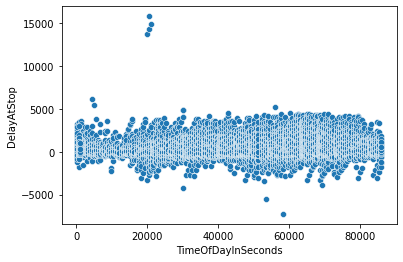

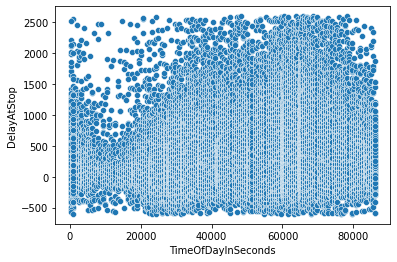

In [8]:
# scatter plot of 'DelayAtStop' vs. 'TimeOfDayInSeconds'
plt.figure()
sns.scatterplot(data=data, x='TimeOfDayInSeconds', y='DelayAtStop')

# ... same scatter plot but with outliers removed
plt.figure()
sns.scatterplot(
    data=data[
        (data['DelayAtStop'] < data['DelayAtStop'].quantile(0.99))
        & (data['DelayAtStop'] > data['DelayAtStop'].quantile(0.01))], 
    x='TimeOfDayInSeconds', 
    y='DelayAtStop')


Text(0.5, 1.0, 'DelayAtStop vs. TimeOfDayInSeconds (bus line: B6)')

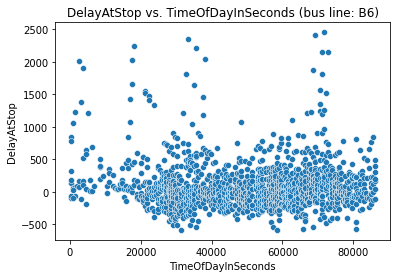

In [9]:
# ... same scatter plot but of a single bus line, e.g. the one with the most data points
data_point_count = data.groupby(['PublishedLineName']).size().reset_index(drop = False, name = 'Count').sort_values(by = ['Count'], ascending = False)
bus_line = data_point_count.loc[data_point_count['Count'].idxmax()]['PublishedLineName']

plt.figure()
ax = sns.scatterplot(
    data=data[
        (data['DelayAtStop'] < data['DelayAtStop'].quantile(0.99))
        & (data['DelayAtStop'] > data['DelayAtStop'].quantile(0.01))
        & (data['PublishedLineName'] == bus_line)], 
    x='TimeOfDayInSeconds', 
    y='DelayAtStop')

ax.set_title(f'DelayAtStop vs. TimeOfDayInSeconds (bus line: {bus_line})')


## Delay Prediction at Bus Stop

In [10]:
# load train and validation data : train on June data, test on August
train_data = data
validation_data = load_data(DATA_DIR, [8], nrows=NROWS)


In [11]:
len(train_data), len(validation_data)


(68031, 68568)

In [12]:
def add_categorical_features(data:pd.DataFrame, features:list = ['BusLine_Direction', 'NextStopPointName']):
    data['BusLine_Direction'] = data['PublishedLineName'] + '_' + data['DirectionRef'].astype(str)
    data[categorical] = data[categorical].astype(str)


In [13]:
# we use the following as input features:
# - categorical : ['PublishedLineName', 'DirectionRef', 'NextStopPointName']
# - numerical : ['TimeOfDayInSeconds', 'DayOfWeek']
#
# our target : 'DelayAtStop'
categorical = ['BusLine_Direction', 'NextStopPointName']
numerical = ['TimeOfDayInSeconds', 'DayOfWeek']
target = 'DelayAtStop'

add_categorical_features(train_data, categorical)
add_categorical_features(validation_data, categorical)


In [14]:
dv = DictVectorizer()

train_dicts = train_data[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = train_data[target].values

val_dicts = validation_data[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = validation_data[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)


637.4265505011952